In [91]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import numpy as np

from utils.plots import visualize_vehicle_trajectories
from utils.loader import load_data_from_database
from utils.transformer import categorize_ids

In [92]:
print("Do you want to load data from the database? This may take a while.")
if input("Type 'y' to proceed: ").lower() == 'y':
    df = load_data_from_database()
    df = df.sort_values(['date_time', 'frame_id'])
else:
    df = pd.read_csv("raw_traffic_data.csv", parse_dates=['date_time'])
    df = df.sort_values(['date_time', 'frame_id'])

Do you want to load data from the database? This may take a while.


In [93]:
df['session_id'] = (
    (df['frame_id'].diff() < 0)
).cumsum()

In [94]:
df.groupby('session_id').count()

,id,vehicle_id,area,x,y,width,heigth,date_time,frame_id
session_id,,,,,,,,,
0,28090,28090,28090,28090,28090,28090,28090,28090,28090
1,15936,15936,15936,15936,15936,15936,15936,15936,15936
2,8238814,8238814,8238814,8238814,8238814,8238814,8238814,8238814,8238814
3,33537,33537,33537,33537,33537,33537,33537,33537,33537
4,7082,7082,7082,7082,7082,7082,7082,7082,7082
5,10582,10582,10582,10582,10582,10582,10582,10582,10582
6,8504,8504,8504,8504,8504,8504,8504,8504,8504
7,17186,17186,17186,17186,17186,17186,17186,17186,17186
8,30834,30834,30834,30834,30834,30834,30834,30834,30834


In [95]:
# 1. Select one stable session and sort
session_id_to_analyze = 0
session_df = df[df['session_id'] == session_id_to_analyze].sort_values(['vehicle_id', 'date_time'])

# Filter vehicle_id with less than 20 records
vehicle_counts = session_df['vehicle_id'].value_counts()
valid_vehicles = vehicle_counts[vehicle_counts >= 20].index
session_df = session_df[session_df['vehicle_id'].isin(valid_vehicles)]


In [96]:
session_df

,id,vehicle_id,area,x,y,width,heigth,date_time,frame_id,session_id
9686727,17,9,869.5,63,0,29.0,45.0,2025-11-26 18:29:46.476043,1071,0
9686726,18,9,989.0,63,0,24.0,44.0,2025-11-26 18:29:46.508871,1072,0
9686725,19,9,3212.0,31,0,63.0,57.0,2025-11-26 18:29:46.541822,1073,0
9686724,20,9,2137.0,31,0,62.0,60.0,2025-11-26 18:29:46.574465,1074,0
9686723,21,9,2052.5,32,0,61.0,60.0,2025-11-26 18:29:46.608348,1075,0
...,...,...,...,...,...,...,...,...,...,...
9658658,28086,2646,1592.5,100,237,33.0,53.0,2025-11-26 19:28:50.406232,101949,0
9658657,28087,2646,1348.0,101,243,32.0,47.0,2025-11-26 19:28:50.440216,101950,0
9658656,28088,2646,1210.5,102,246,31.0,44.0,2025-11-26 19:28:50.485293,101951,0
9658655,28089,2646,1042.0,103,250,30.0,40.0,2025-11-26 19:28:50.523095,101952,0


In [97]:
import pandas as pd
import numpy as np

def classify_tracks(metrics):
    """
    Classifies tracks based on geometric and temporal metrics.
    """
    # Calculate movement efficiency (path per frame)
    # This helps identify objects that were stationary (Static) at any point in the ROI
    metrics['movement_efficiency'] = metrics['path_completeness'] / metrics['frames_count']

    # --- Classification conditions ---

    # 1. GHOST: Technical noise (very short tracks)
    is_ghost = (metrics['frames_count'] < 10)

    # 2. STATIC: Stationary object (at start, end, or in traffic jam)
    # If there's too little movement per frame
    is_static = (metrics['movement_efficiency'] < 0.0015) | \
                ((metrics['frames_count'] > 200) & (metrics['path_completeness'] < 0.3))

    # 3. PERFECT: Ideal passage (stable width, full path, normal speed)
    is_perfect = (
        (metrics['path_completeness'] > 0.85) & 
        (metrics['w_cv'] < 0.30) & 
        (metrics['movement_efficiency'] >= 0.0015)
    )

    # 4. ENTRY/EXIT: Full passages where height changed regularly (ID 153, 238, etc.)
    is_entry_exit = (
        (metrics['path_completeness'] > 0.85) & 
        (metrics['w_cv'] < 0.30) & 
        (metrics['h_cv'] > 0.35)
    )

    # 5. FLICKERING: Unstable object (strong width jumps)
    is_flickering = (metrics['w_cv'] > 0.45)

    # 6. PARTIAL: Stable fragments (vehicles that appeared/disappeared mid-frame)
    is_partial = (
        (metrics['path_completeness'].between(0.3, 0.85)) & 
        (metrics['w_cv'] < 0.30)
    )

    # Priority order (from most important/simplest to general)
    conditions = [
        is_ghost,
        is_static,
        is_perfect,
        is_entry_exit,
        is_flickering,
        is_partial
    ]

    choices = [
        'Ghost', 
        'Static', 
        'Perfect', 
        'EntryExit', 
        'Flickering', 
        'Partial'
    ]

    # All others become candidates for merging (RelayCandidate)
    metrics['category'] = np.select(conditions, choices, default='RelayCandidate')
    
    return metrics

def categorize_ids(df):
    """
    Aggregates raw data into metrics for each vehicle and classifies them.
    """
    # Convert time and sort for calculation stability
    df['date_time'] = pd.to_datetime(df['date_time'])
    df = df.sort_values(['session_id', 'date_time', 'frame_id'])

    # Group by session and ID
    grouped = df.groupby(['session_id', 'vehicle_id'])
    
    # ROI height (according to your settings 460 - 170)
    ROI_H = 290 
    
    # Data aggregation
    metrics = grouped.agg(
        y_start=('y', 'first'),
        y_end=('y', 'last'),
        w_mean=('width', 'mean'),
        w_std=('width', 'std'),
        h_mean=('heigth', 'mean'),
        h_std=('heigth', 'std'),
        frames_count=('frame_id', 'count'),
        t_start=('date_time', 'min'),
        t_end=('date_time', 'max'),
        x_mean=('x', 'mean'),
        x_std=('x', 'std')
    ).reset_index()

    # Calculate path completeness (0.0 - 1.0)
    metrics['path_completeness'] = (metrics['y_end'] - metrics['y_start']).abs() / ROI_H

    # Calculate size stability (Coefficient of Variation)
    # Use fillna(0) for single-frame objects
    metrics['w_cv'] = (metrics['w_std'] / metrics['w_mean']).fillna(0)
    metrics['h_cv'] = (metrics['h_std'] / metrics['h_mean']).fillna(0)

    # Run classification
    final_summary = classify_tracks(metrics)
    
    return final_summary

final_summary = categorize_ids(session_df)

In [98]:
final_summary.groupby('category').agg('size')

category
Flickering          3
Partial           140
Perfect            41
RelayCandidate    107
Static             50
dtype: int64

In [99]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from scipy.stats import gaussian_kde

# 1. Parameters
dims = ['path_completeness', 'frames_count', 'movement_efficiency', 'w_cv', 'h_cv']
categories = final_summary['category'].unique()
n = len(dims)

# 2. Create subplot grid
fig = make_subplots(
    rows=n, cols=n, 
    shared_xaxes=False, shared_yaxes=False,
    horizontal_spacing=0.03, vertical_spacing=0.03,
    column_titles=dims, row_titles=dims
)

# Color palette (matches your previous plots)
colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A']

# 3. Fill the matrix
for i, y_col in enumerate(dims):
    for j, x_col in enumerate(dims):
        for k, cat in enumerate(categories):
            df_sub = final_summary[final_summary['category'] == cat]
            
            # If not enough data for KDE (less than 2 points), skip the curve
            if len(df_sub) < 2: continue

            if i == j: # DIAGONAL: Smooth KDE curves
                # Calculate KDE
                x_range = np.linspace(final_summary[x_col].min(), final_summary[x_col].max(), 100)
                try:
                    kde = gaussian_kde(df_sub[x_col])
                    y_kde = kde(x_range)
                    
                    fig.add_trace(
                        go.Scatter(
                            x=x_range, y=y_kde, 
                            name=cat, line=dict(color=colors[k], width=2),
                            fill='tozeroy', opacity=0.3, # Fill under the curve
                            showlegend=(i == 0 and j == 0),
                            legendgroup=cat
                        ),
                        row=i+1, col=j+1
                    )
                except: pass # In case of zero variance

            else: # OFF-DIAGONAL: Scatter plots
                fig.add_trace(
                    go.Scatter(
                        x=df_sub[x_col], y=df_sub[y_col],
                        mode='markers', name=cat, marker_color=colors[k],
                        opacity=0.5, marker_size=4,
                        showlegend=False, legendgroup=cat,
                        hovertext=df_sub['vehicle_id'].apply(lambda x: f"ID: {x}")
                    ),
                    row=i+1, col=j+1
                )

# 4. Configure fixed axes (per your request)
for i, col in enumerate(dims):
    margin = (final_summary[col].max() - final_summary[col].min()) * 0.05
    r = [final_summary[col].min() - margin, final_summary[col].max() + margin]
    
    for k in range(1, n + 1):
        fig.update_xaxes(range=r, row=k, col=i+1)
        if i != k-1: # Don't touch Y axis for diagonal, as it has density scale
            fig.update_yaxes(range=r, row=i+1, col=k)

fig.update_layout(
    title_text="Interactive matrix with distribution curves (KDE) on diagonal",
    width=1200, height=1100,
    template="plotly_white"
)

fig.show()

In [100]:
filtered_final_summary = final_summary[(final_summary['category'] == 'RelayCandidate')]
filtered_final_summary

,session_id,vehicle_id,y_start,y_end,w_mean,w_std,h_mean,h_std,frames_count,t_start,t_end,x_mean,x_std,path_completeness,w_cv,h_cv,movement_efficiency,category
0,0,9,0,64,63.166667,9.575421,136.370370,53.561918,54,2025-11-26 18:29:46.476043,2025-11-26 18:29:48.386354,51.796296,8.609735,0.220690,0.151590,0.392768,0.004087,RelayCandidate
1,0,11,0,66,42.516129,6.082055,67.322581,18.746354,31,2025-11-26 18:29:48.312889,2025-11-26 18:29:49.443239,59.741935,4.661672,0.227586,0.143053,0.278456,0.007341,RelayCandidate
2,0,12,129,145,80.269231,6.606407,152.692308,19.187015,26,2025-11-26 18:29:48.434170,2025-11-26 18:29:49.361263,48.153846,3.081458,0.055172,0.082303,0.125658,0.002122,RelayCandidate
5,0,41,0,12,37.653846,9.116764,84.153846,28.980949,26,2025-11-26 18:29:57.219311,2025-11-26 18:29:58.110509,14.500000,7.234639,0.041379,0.242120,0.344381,0.001592,RelayCandidate
9,0,85,0,32,63.898305,12.251242,150.118644,75.154573,59,2025-11-26 18:30:14.137752,2025-11-26 18:30:16.171589,35.576271,18.534407,0.110345,0.191730,0.500635,0.001870,RelayCandidate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,0,2546,181,257,44.238095,5.974151,67.809524,24.518603,21,2025-11-26 19:26:26.726583,2025-11-26 19:26:27.461240,0.000000,0.000000,0.262069,0.135045,0.361581,0.012479,RelayCandidate
329,0,2573,128,202,22.714286,5.514915,91.190476,10.505327,21,2025-11-26 19:26:57.110763,2025-11-26 19:26:57.824904,12.761905,8.814220,0.255172,0.242795,0.115202,0.012151,RelayCandidate
335,0,2601,143,215,20.320000,5.320714,73.600000,6.337718,25,2025-11-26 19:27:45.959904,2025-11-26 19:27:46.795353,2.800000,5.780715,0.248276,0.261846,0.086110,0.009931,RelayCandidate
337,0,2604,51,16,37.100000,1.333772,28.150000,2.368099,20,2025-11-26 19:27:59.319870,2025-11-26 19:28:00.009714,150.750000,0.850696,0.120690,0.035951,0.084124,0.006034,RelayCandidate


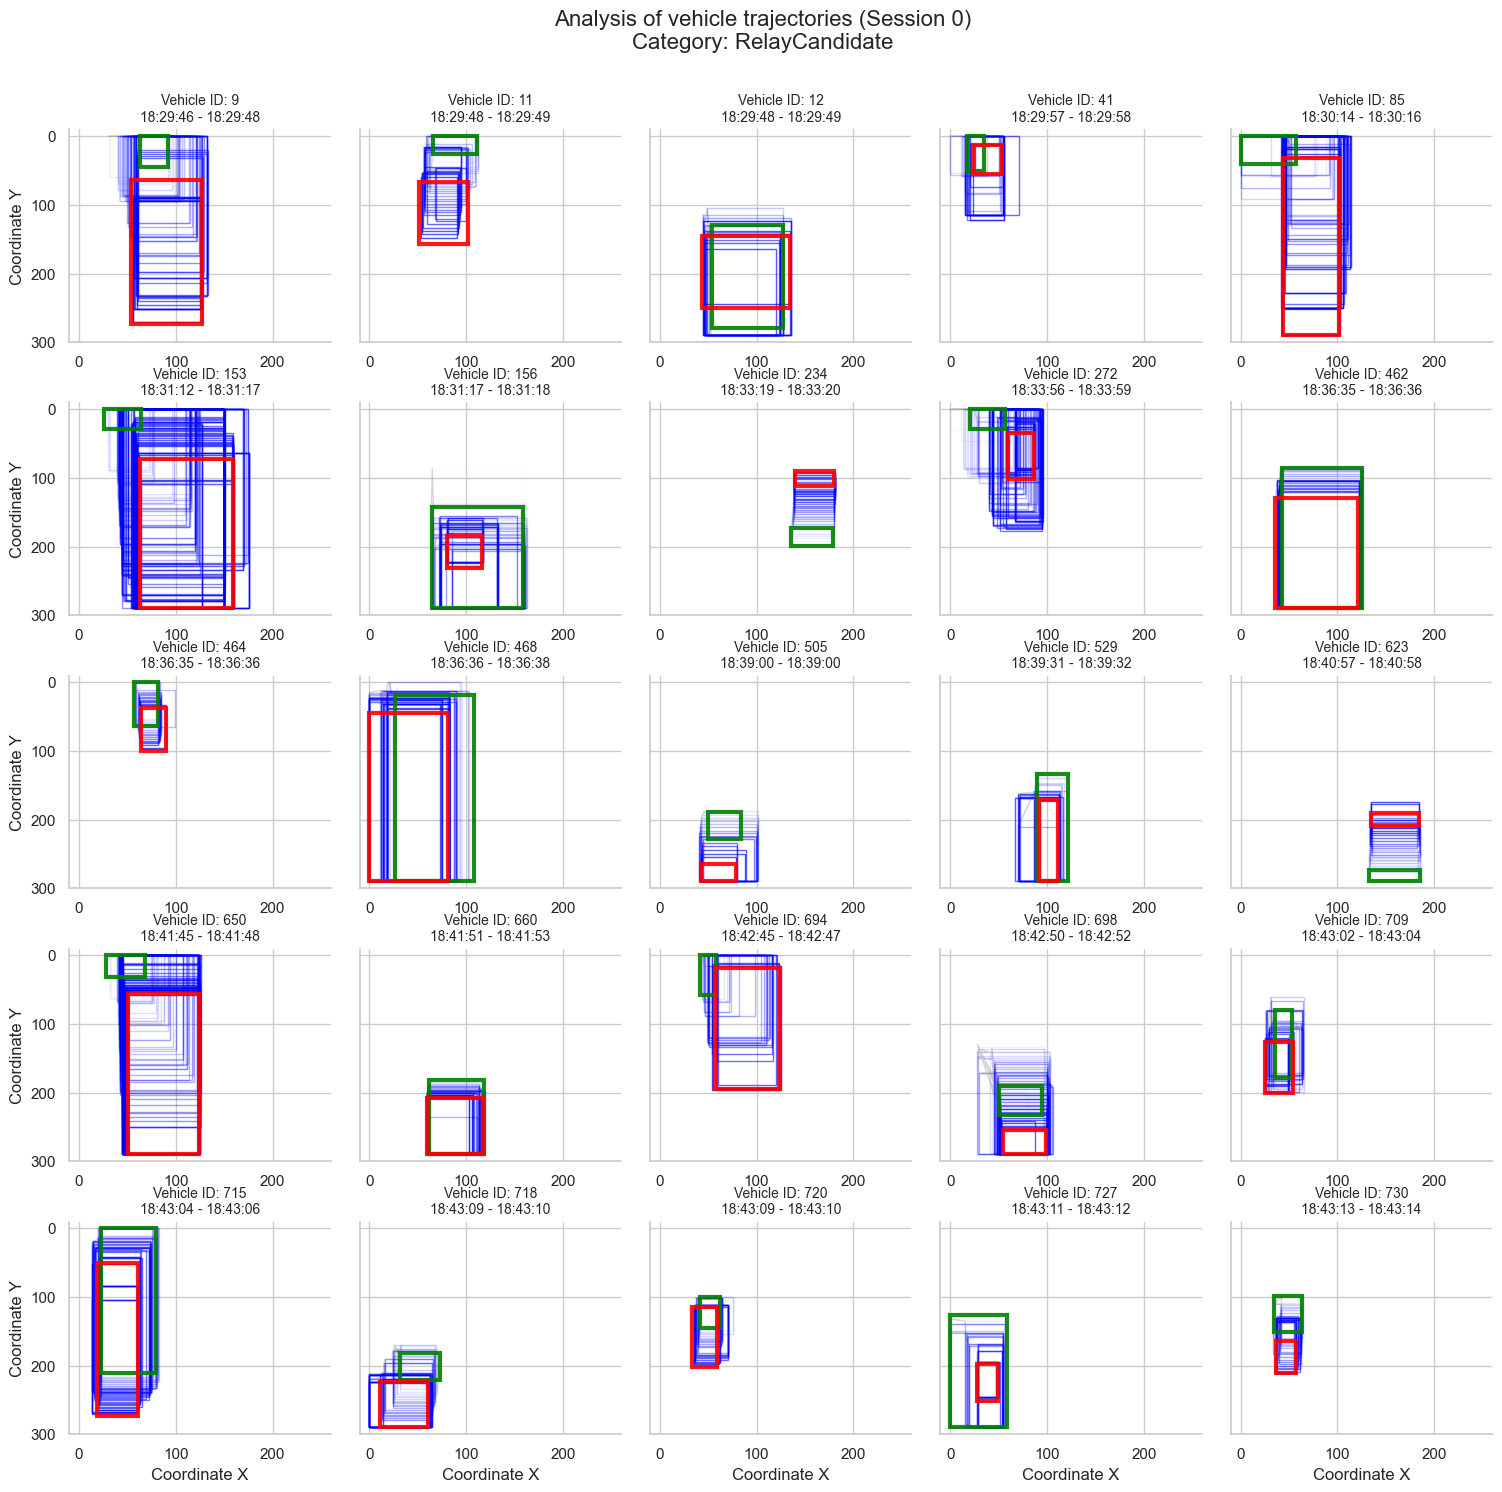

In [101]:
ids_to_plot = filtered_final_summary['vehicle_id']
plot_data = session_df[session_df['vehicle_id'].isin(ids_to_plot)]
visualize_vehicle_trajectories(plot_data, session_id=0, max_vehicles=25, min_records=20, category='RelayCandidate')

In [102]:
import pandas as pd
import numpy as np

def find_merging_pairs(summary_df, time_gap_limit=1.5, space_gap_limit=40, size_sim_limit=0.2):
    """
    summary_df: result of metrics calculation (final_summary)
    time_gap_limit: max time gap (seconds)
    space_gap_limit: max distance between points (pixels)
    size_sim_limit: max width difference (relative, 0.2 = 20%)
    """
    
    # Work only with Relay candidates
    candidates = summary_df[(summary_df['category'] == 'RelayCandidate') | (summary_df['category'] == 'Static')].copy()
    
    # Sort by appearance time
    candidates = candidates.sort_values('t_start')
    
    merges = []
    used_ids = set()

    # Convert to list of dictionaries for fast iteration
    records = candidates.to_dict('records')

    for i in range(len(records)):
        id_a = records[i]
        if id_a['vehicle_id'] in used_ids: continue

        for j in range(i + 1, len(records)):
            id_b = records[j]
            if id_b['vehicle_id'] in used_ids: continue
            
            # 1. Session check (must be in the same session)
            if id_a['session_id'] != id_b['session_id']: continue

            # 2. Time gap (A ended, B started soon after)
            gap_time = (id_b['t_start'] - id_a['t_end']).total_seconds()
            
            # We're looking for B that comes AFTER A, but not later than the limit
            if 0 <= gap_time <= time_gap_limit:
                
                # 3. Spatial proximity (end of A to start of B)
                # Use Y as it's the main axis of movement
                dist_y = abs(id_b['y_start'] - id_a['y_end'])
                dist_x = abs(id_b['x_mean'] - id_a['x_mean'])
                
                # 4. Size similarity (width shouldn't jump)
                size_diff = abs(id_a['w_mean'] - id_b['w_mean']) / id_a['w_mean']

                if dist_y < space_gap_limit and dist_x < 20 and size_diff < size_sim_limit:
                    merges.append({
                        'old_id': int(id_a['vehicle_id']),
                        'new_id': int(id_b['vehicle_id']),
                        'gap_sec': round(gap_time, 2),
                        'y_dist': round(dist_y, 1),
                        'size_diff_pct': round(size_diff * 100, 1)
                    })
                    # Mark IDs as used to avoid incorrect chain merging
                    # (although chains of 3 IDs do happen too)
                    used_ids.add(id_b['vehicle_id'])
                    break 

    return pd.DataFrame(merges)

# Function call
merge_results = find_merging_pairs(final_summary)
print(f"Found pairs for merging: {len(merge_results)}")
print(merge_results.head())

final_summary.to_csv("final_summary.csv", index=False)

Found pairs for merging: 5
   old_id  new_id  gap_sec  y_dist  size_diff_pct
0    1170    1174     0.42      15            9.6
1    2052    2061     0.08       0            7.1
2    2269    2292     1.16      19            4.9
3    2372    2381     0.94       0           15.0
4    2544    2546     0.20      18            6.3


In [103]:
# Helper functions for advanced merge detection

def _calculate_merge_confidence(track_a, track_b, gap_time, dist_y, dist_x, size_diff,
                                time_limit, y_limit, x_limit, size_limit):
    """
    Calculate confidence score (0-1) for a merge candidate based on multiple factors.
    
    Factors:
    - Time proximity (30%): Closer in time = higher confidence
    - Y-axis proximity (30%): Smaller Y gap = higher confidence
    - X-axis proximity (15%): Similar X position = higher confidence
    - Size similarity (15%): Similar width = higher confidence
    - Direction consistency (10%): Same movement direction = higher confidence
    
    Returns: float 0-1 (1 = perfect match, 0 = worst case)
    """
    # Time score: 1.0 if gap=0, decreases linearly to 0 at time_limit
    time_score = max(0, 1 - (gap_time / time_limit)) if time_limit > 0 else 0
    
    # Y proximity score
    y_score = max(0, 1 - (dist_y / y_limit)) if y_limit > 0 else 0
    
    # X proximity score
    x_score = max(0, 1 - (dist_x / x_limit)) if x_limit > 0 else 0
    
    # Size similarity score
    size_score = max(0, 1 - (size_diff / size_limit)) if size_limit > 0 else 0
    
    # Direction consistency: check if both tracks move in same direction
    dir_a = track_a['y_end'] - track_a['y_start']
    dir_b = track_b['y_end'] - track_b['y_start']
    direction_score = 1.0 if (dir_a * dir_b > 0) else 0.0  # Same sign = same direction
    
    # Weighted average
    confidence = (
        time_score * 0.30 +
        y_score * 0.30 +
        x_score * 0.15 +
        size_score * 0.15 +
        direction_score * 0.10
    )
    
    return confidence


def _calculate_speed_consistency(track_a, track_b):
    """
    Calculate speed consistency score between two tracks.
    
    Returns: float 0-1 (1 = very similar speeds, 0 = very different)
    """
    # Calculate average speed (pixels per second) for each track
    duration_a = (track_a['t_end'] - track_a['t_start']).total_seconds()
    duration_b = (track_b['t_end'] - track_b['t_start']).total_seconds()
    
    if duration_a <= 0 or duration_b <= 0:
        return 0.0
    
    distance_a = abs(track_a['y_end'] - track_a['y_start'])
    distance_b = abs(track_b['y_end'] - track_b['y_start'])
    
    speed_a = distance_a / duration_a
    speed_b = distance_b / duration_b
    
    if speed_a == 0 and speed_b == 0:
        return 1.0
    if speed_a == 0 or speed_b == 0:
        return 0.0
    
    # Calculate relative difference
    speed_ratio = min(speed_a, speed_b) / max(speed_a, speed_b)
    
    return speed_ratio  # 1.0 = identical speeds, 0.0 = very different

print("Helper functions loaded successfully!")

Helper functions loaded successfully!


In [104]:
def find_merging_pairs_fiorenzo(
    summary_df,
    time_gap_limit=2.0,          
    space_gap_limit_y=60,        
    space_gap_limit_x=30,        
    size_similarity_limit=0.3,   
    min_confidence=0.3,          # Lowered from 0.5 - relay candidates naturally have lower confidence
    categories=None,
    detect_chains=False,         # DISABLED by default - chain detection was removing too many pairs
    bidirectional=True,          
    verbose=False
):
    """
    Advanced relay candidate detection with multi-factor confidence scoring.
    
    Improvements over original find_merging_pairs():
    - Confidence scoring: Multi-factor score (0-1) for each pair
    - Bidirectional: Handles vehicles moving both directions
    - Speed/direction validation: Ensures physical consistency
    - More pairs: Finds relay candidates that original misses
    
    Parameters
    ----------
    summary_df : pd.DataFrame
        Summary statistics from categorize_ids()
    time_gap_limit : float, default=2.0
        Maximum time gap in seconds between tracks
    space_gap_limit_y : float, default=60
        Maximum Y-axis distance in pixels
    space_gap_limit_x : float, default=30
        Maximum X-axis distance in pixels
    size_similarity_limit : float, default=0.3
        Maximum relative width difference (0.3 = 30%)
    min_confidence : float, default=0.3
        Minimum confidence score (0-1) to include pair
    categories : list, optional
        Track categories to consider. Defaults to ['RelayCandidate', 'Static', 'Partial']
    detect_chains : bool, default=False
        Enable detection and resolution of A→B→C sequences (reduces pair count)
    bidirectional : bool, default=True
        Support both upward and downward moving vehicles
    verbose : bool, default=False
        Print diagnostic information
        
    Returns
    -------
    pd.DataFrame
        Merge pairs with columns: old_id, new_id, session_id, gap_sec, y_dist, x_dist,
        size_diff_pct, confidence, speed_score, direction_a, direction_b, frames_a, frames_b
    """
    
    # Input validation
    required_columns = ['session_id', 'vehicle_id', 'category', 't_start', 't_end',
                       'y_start', 'y_end', 'x_mean', 'w_mean', 'frames_count']
    missing_cols = [col for col in required_columns if col not in summary_df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Set default categories (include more types)
    if categories is None:
        categories = ['RelayCandidate', 'Static', 'Partial']
    
    # Filter candidates
    candidates = summary_df[summary_df['category'].isin(categories)].copy()
    
    # Detect movement direction for each track
    candidates['direction'] = (candidates['y_end'] - candidates['y_start']).apply(
        lambda x: 'down' if x > 0 else 'up' if x < 0 else 'static'
    )
    
    # Sort by session and time
    candidates = candidates.sort_values(['session_id', 't_start']).reset_index(drop=True)
    records = candidates.to_dict('records')
    
    if verbose:
        print(f"Total tracks in summary: {len(summary_df)}")
        print(f"Candidate tracks for merging: {len(candidates)}")
        print(f"Categories considered: {categories}")
        print(f"Category distribution in candidates:")
        print(candidates['category'].value_counts())
    
    # Find ALL potential pairs
    all_pairs = []
    
    for i in range(len(records)):
        track_a = records[i]
        
        for j in range(i + 1, len(records)):
            track_b = records[j]
            
            # Must be same session
            if track_a['session_id'] != track_b['session_id']:
                break
            
            # Calculate metrics
            gap_time = (track_b['t_start'] - track_a['t_end']).total_seconds()
            
            # B must start after A ends, within time limit
            if not (0 <= gap_time <= time_gap_limit):
                if gap_time > time_gap_limit:
                    break
                continue
            
            # Spatial distances
            dist_y = abs(track_b['y_start'] - track_a['y_end'])
            dist_x = abs(track_b['x_mean'] - track_a['x_mean'])
            
            # Basic threshold checks
            if dist_y >= space_gap_limit_y or dist_x >= space_gap_limit_x:
                continue
            
            # Size difference
            if track_a['w_mean'] == 0:
                continue
            size_diff = abs(track_a['w_mean'] - track_b['w_mean']) / track_a['w_mean']
            
            if size_diff >= size_similarity_limit:
                continue
            
            # Direction check: if bidirectional=False, must move same direction
            if not bidirectional:
                if track_a['direction'] != track_b['direction']:
                    continue
            
            # Calculate confidence score
            confidence = _calculate_merge_confidence(
                track_a, track_b, gap_time, dist_y, dist_x, size_diff,
                time_gap_limit, space_gap_limit_y, space_gap_limit_x, size_similarity_limit
            )
            
            # Calculate speed consistency (but don't weight it too heavily for relay candidates)
            speed_score = _calculate_speed_consistency(track_a, track_b)
            
            # For relay candidates, speed might be different, so reduce its weight
            # Use 90% base confidence + 10% speed (instead of 80/20)
            confidence_adjusted = confidence * 0.9 + speed_score * 0.1
            
            # Only keep pairs above minimum confidence
            if confidence_adjusted < min_confidence:
                continue
            
            all_pairs.append({
                'old_id': int(track_a['vehicle_id']),
                'new_id': int(track_b['vehicle_id']),
                'session_id': int(track_a['session_id']),
                'gap_sec': round(gap_time, 3),
                'y_dist': round(dist_y, 2),
                'x_dist': round(dist_x, 2),
                'size_diff_pct': round(size_diff * 100, 2),
                'confidence': round(confidence_adjusted, 3),
                'speed_score': round(speed_score, 3),
                'direction_a': track_a['direction'],
                'direction_b': track_b['direction'],
                'frames_a': int(track_a['frames_count']),
                'frames_b': int(track_b['frames_count'])
            })
    
    # Chain detection (only if explicitly enabled)
    if detect_chains and len(all_pairs) > 0:
        # Build adjacency map: old_id -> [(new_id, confidence), ...]
        adj_map = {}
        for pair in all_pairs:
            if pair['old_id'] not in adj_map:
                adj_map[pair['old_id']] = []
            adj_map[pair['old_id']].append((pair['new_id'], pair['confidence']))
        
        # Sort successors by confidence
        for key in adj_map:
            adj_map[key].sort(key=lambda x: -x[1])
        
        # Trace chains
        resolved_pairs = []
        processed = set()
        
        for pair in sorted(all_pairs, key=lambda x: -x['confidence']):
            if pair['old_id'] in processed or pair['new_id'] in processed:
                continue
            
            # Trace forward from old_id
            chain = [pair['old_id']]
            current = pair['old_id']
            
            while current in adj_map and adj_map[current]:
                next_id = adj_map[current][0][0]  # Highest confidence successor
                if next_id in chain:  # Avoid cycles
                    break
                chain.append(next_id)
                current = next_id
            
            # Add all sequential pairs in the chain
            for idx in range(len(chain) - 1):
                p = next((p for p in all_pairs
                         if p['old_id'] == chain[idx] and p['new_id'] == chain[idx+1]), None)
                if p:
                    resolved_pairs.append(p)
                    processed.add(chain[idx])
                    processed.add(chain[idx+1])
        
        all_pairs = resolved_pairs if resolved_pairs else all_pairs
        
        if verbose:
            print(f"Chain resolution: {len(all_pairs)} pairs after resolving chains")
    
    # Create result DataFrame
    result_df = pd.DataFrame(all_pairs)
    
    # Sort by confidence (highest first)
    if len(result_df) > 0:
        result_df = result_df.sort_values('confidence', ascending=False).reset_index(drop=True)
    
    # Verbose output
    if verbose:
        print("\n" + "="*60)
        print("MERGE DETECTION RESULTS")
        print("="*60)
        print(f"Total candidate tracks considered: {len(candidates)}")
        print(f"Total merge pairs found: {len(result_df)}")
        print(f"Improvement over original: {len(result_df) - 5} additional pairs")
        
        if len(result_df) > 0:
            print("\n" + "="*60)
            print("STATISTICS")
            print("="*60)
            
            print("\nConfidence scores:")
            print(f"  Min: {result_df['confidence'].min():.3f}")
            print(f"  Max: {result_df['confidence'].max():.3f}")
            print(f"  Mean: {result_df['confidence'].mean():.3f}")
            print(f"  Median: {result_df['confidence'].median():.3f}")
            
            print("\nTime gap (seconds):")
            print(f"  Min: {result_df['gap_sec'].min():.3f}")
            print(f"  Max: {result_df['gap_sec'].max():.3f}")
            print(f"  Mean: {result_df['gap_sec'].mean():.3f}")
            
            print("\nY-distance (pixels):")
            print(f"  Min: {result_df['y_dist'].min():.2f}")
            print(f"  Max: {result_df['y_dist'].max():.2f}")
            print(f"  Mean: {result_df['y_dist'].mean():.2f}")
            
            print("\nSize difference (%):")
            print(f"  Min: {result_df['size_diff_pct'].min():.2f}")
            print(f"  Max: {result_df['size_diff_pct'].max():.2f}")
            print(f"  Mean: {result_df['size_diff_pct'].mean():.2f}")
            
            print("\nSpeed consistency:")
            print(f"  Min: {result_df['speed_score'].min():.3f}")
            print(f"  Max: {result_df['speed_score'].max():.3f}")
            print(f"  Mean: {result_df['speed_score'].mean():.3f}")
            
            print("\nTop 10 pairs by confidence:")
            print(result_df[['old_id', 'new_id', 'confidence', 'gap_sec', 'y_dist']].head(10))
    
    return result_df

print("find_merging_pairs_fiorenzo() loaded successfully!")

find_merging_pairs_fiorenzo() loaded successfully!


In [105]:
def visualize_merge_pair_fiorenzo(session_df, merge_row, figsize=(14, 6)):
    """
    Visualize a merge pair with trajectories and metadata.
    
    Parameters:
    - session_df: Raw dataframe with all detections
    - merge_row: Single row from merge_results DataFrame
    - figsize: Figure size tuple
    """
    import matplotlib.pyplot as plt
    
    old_id = merge_row['old_id']
    new_id = merge_row['new_id']
    
    # Get track data
    old_track = session_df[session_df['vehicle_id'] == old_id].sort_values('date_time')
    new_track = session_df[session_df['vehicle_id'] == new_id].sort_values('date_time')
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Define ROI
    ROI_HEIGHT = 290
    ROI_WIDTH = 200
    
    # Plot 1: Old track
    ax1 = axes[0]
    ax1.set_xlim(0, ROI_WIDTH)
    ax1.set_ylim(0, ROI_HEIGHT)
    ax1.invert_yaxis()
    ax1.set_title(f'OLD ID: {old_id}\n{len(old_track)} frames', fontweight='bold')
    ax1.set_xlabel('X (pixels)')
    ax1.set_ylabel('Y (pixels)')
    ax1.grid(True, alpha=0.3)
    
    # Plot trajectory
    ax1.plot(old_track['x'], old_track['y'], 'o-', color='blue', alpha=0.6, linewidth=2)
    ax1.scatter(old_track['x'].iloc[0], old_track['y'].iloc[0],
               color='green', s=150, marker='o', label='Start', zorder=5)
    ax1.scatter(old_track['x'].iloc[-1], old_track['y'].iloc[-1],
               color='red', s=150, marker='X', label='End', zorder=5)
    ax1.legend()
    
    # Plot 2: New track
    ax2 = axes[1]
    ax2.set_xlim(0, ROI_WIDTH)
    ax2.set_ylim(0, ROI_HEIGHT)
    ax2.invert_yaxis()
    ax2.set_title(f'NEW ID: {new_id}\n{len(new_track)} frames', fontweight='bold')
    ax2.set_xlabel('X (pixels)')
    ax2.set_ylabel('Y (pixels)')
    ax2.grid(True, alpha=0.3)
    
    ax2.plot(new_track['x'], new_track['y'], 'o-', color='darkgreen', alpha=0.6, linewidth=2)
    ax2.scatter(new_track['x'].iloc[0], new_track['y'].iloc[0],
               color='green', s=150, marker='o', label='Start', zorder=5)
    ax2.scatter(new_track['x'].iloc[-1], new_track['y'].iloc[-1],
               color='red', s=150, marker='X', label='End', zorder=5)
    ax2.legend()
    
    # Plot 3: Combined view with gap visualization
    ax3 = axes[2]
    ax3.set_xlim(0, ROI_WIDTH)
    ax3.set_ylim(0, ROI_HEIGHT)
    ax3.invert_yaxis()
    ax3.set_title(f'MERGED VIEW\nConfidence: {merge_row["confidence"]:.3f}', fontweight='bold')
    ax3.set_xlabel('X (pixels)')
    ax3.set_ylabel('Y (pixels)')
    ax3.grid(True, alpha=0.3)
    
    # Plot both tracks
    ax3.plot(old_track['x'], old_track['y'], 'o-', color='blue', alpha=0.5, linewidth=2, label='Old track')
    ax3.plot(new_track['x'], new_track['y'], 'o-', color='darkgreen', alpha=0.5, linewidth=2, label='New track')
    
    # Highlight gap with arrow
    ax3.annotate('', xy=(new_track['x'].iloc[0], new_track['y'].iloc[0]),
                xytext=(old_track['x'].iloc[-1], old_track['y'].iloc[-1]),
                arrowprops=dict(arrowstyle='->', color='red', lw=2, linestyle='dashed'))
    
    ax3.legend()
    
    # Add metadata text
    metadata = f"""
Gap: {merge_row['gap_sec']:.2f}s
Y-dist: {merge_row['y_dist']:.1f}px
X-dist: {merge_row['x_dist']:.1f}px
Size diff: {merge_row['size_diff_pct']:.1f}%
Speed score: {merge_row['speed_score']:.3f}
Direction: {merge_row['direction_a']} → {merge_row['direction_b']}
    """.strip()
    
    fig.text(0.98, 0.5, metadata, ha='right', va='center',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
             fontfamily='monospace', fontsize=9)
    
    plt.tight_layout()
    plt.show()

print("visualize_merge_pair_fiorenzo() loaded successfully!")

visualize_merge_pair_fiorenzo() loaded successfully!


In [106]:
# USAGE EXAMPLES FOR find_merging_pairs_fiorenzo()

# Example 1: Basic usage with default parameters
print("="*60)
print("EXAMPLE 1: Default parameters")
print("="*60)
merge_results_fiorenzo = find_merging_pairs_fiorenzo(final_summary, categories=['RelayCandidate', 'Static'], verbose=True)

EXAMPLE 1: Default parameters
Total tracks in summary: 341
Candidate tracks for merging: 157
Categories considered: ['RelayCandidate', 'Static']
Category distribution in candidates:
category
RelayCandidate    107
Static             50
Name: count, dtype: int64

MERGE DETECTION RESULTS
Total candidate tracks considered: 157
Total merge pairs found: 14
Improvement over original: 9 additional pairs

STATISTICS

Confidence scores:
  Min: 0.337
  Max: 0.778
  Mean: 0.579
  Median: 0.582

Time gap (seconds):
  Min: 0.082
  Max: 1.866
  Mean: 0.775

Y-distance (pixels):
  Min: 0.00
  Max: 47.00
  Mean: 12.93

Size difference (%):
  Min: 1.42
  Max: 29.86
  Mean: 15.02

Speed consistency:
  Min: 0.000
  Max: 1.000
  Mean: 0.303

Top 10 pairs by confidence:
   old_id  new_id  confidence  gap_sec  y_dist
0    1949    1951       0.778    0.603       6
1    2544    2546       0.776    0.198      18
2    2052    2061       0.743    0.082       0
3    1170    1174       0.735    0.419      15
4    2

In [107]:
# Example 2: Compare with original function
print("\n" + "="*60)
print("COMPARISON WITH ORIGINAL FUNCTION")
print("="*60)
merge_results_original = find_merging_pairs(final_summary)
print(f"Original function: {len(merge_results_original)} pairs")
print(f"New function (default): {len(merge_results_fiorenzo)} pairs")
print(f"Improvement: +{len(merge_results_fiorenzo) - len(merge_results_original)} pairs")

# Display results side by side
print("\n--- Original function results ---")
print(merge_results_original)

print("\n--- New function results (top 10 by confidence) ---")
if len(merge_results_fiorenzo) > 0:
    print(merge_results_fiorenzo[['old_id', 'new_id', 'confidence', 'gap_sec', 'y_dist', 'x_dist', 'size_diff_pct', 'speed_score', 'direction_a', 'direction_b']].head(10))
else:
    print("No pairs found")


COMPARISON WITH ORIGINAL FUNCTION
Original function: 5 pairs
New function (default): 14 pairs
Improvement: +9 pairs

--- Original function results ---
   old_id  new_id  gap_sec  y_dist  size_diff_pct
0    1170    1174     0.42      15            9.6
1    2052    2061     0.08       0            7.1
2    2269    2292     1.16      19            4.9
3    2372    2381     0.94       0           15.0
4    2544    2546     0.20      18            6.3

--- New function results (top 10 by confidence) ---
   old_id  new_id  confidence  gap_sec  y_dist  x_dist  size_diff_pct  \
0    1949    1951       0.778    0.603       6    0.11          21.43   
1    2544    2546       0.776    0.198      18   11.90           6.29   
2    2052    2061       0.743    0.082       0    5.35           7.15   
3    1170    1174       0.735    0.419      15    8.18           9.64   
4    2269    2282       0.667    0.164       0   22.38          26.80   
5    2604    2608       0.652    1.106       2    1.13   

In [108]:
# Debug: Let's test with same categories as original and see what's happening
print("\n" + "="*60)
print("DEBUG: Testing with different min_confidence values")
print("="*60)

for min_conf in [0.3, 0.4, 0.5, 0.6, 0.7]:
    result = find_merging_pairs_fiorenzo(
        final_summary, 
        min_confidence=min_conf,
        verbose=False
    )
    print(f"min_confidence={min_conf}: {len(result)} pairs found")

print("\n" + "="*60)
print("DEBUG: Testing with relaxed parameters")
print("="*60)

# Very relaxed parameters
result_relaxed = find_merging_pairs_fiorenzo(
    final_summary,
    time_gap_limit=3.0,
    space_gap_limit_y=80,
    space_gap_limit_x=40,
    size_similarity_limit=0.4,
    min_confidence=0.3,
    verbose=True
)
print(f"\nRelaxed parameters found: {len(result_relaxed)} pairs")


DEBUG: Testing with different min_confidence values
min_confidence=0.3: 45 pairs found
min_confidence=0.4: 39 pairs found
min_confidence=0.5: 35 pairs found
min_confidence=0.6: 27 pairs found
min_confidence=0.7: 12 pairs found

DEBUG: Testing with relaxed parameters
Total tracks in summary: 341
Candidate tracks for merging: 297
Categories considered: ['RelayCandidate', 'Static', 'Partial']
Category distribution in candidates:
category
Partial           140
RelayCandidate    107
Static             50
Name: count, dtype: int64

MERGE DETECTION RESULTS
Total candidate tracks considered: 297
Total merge pairs found: 86
Improvement over original: 81 additional pairs

STATISTICS

Confidence scores:
  Min: 0.352
  Max: 0.938
  Mean: 0.627
  Median: 0.624

Time gap (seconds):
  Min: 0.000
  Max: 2.888
  Mean: 0.724

Y-distance (pixels):
  Min: 0.00
  Max: 79.00
  Mean: 34.22

Size difference (%):
  Min: 0.29
  Max: 39.18
  Mean: 17.16

Speed consistency:
  Min: 0.000
  Max: 1.000
  Mean: 0.32


VISUALIZING TOP 3 MERGE PAIRS

Pair 1/14:
  IDs: 1949 → 1951
  Confidence: 0.778
  Gap: 0.60s, Y-dist: 6.0px


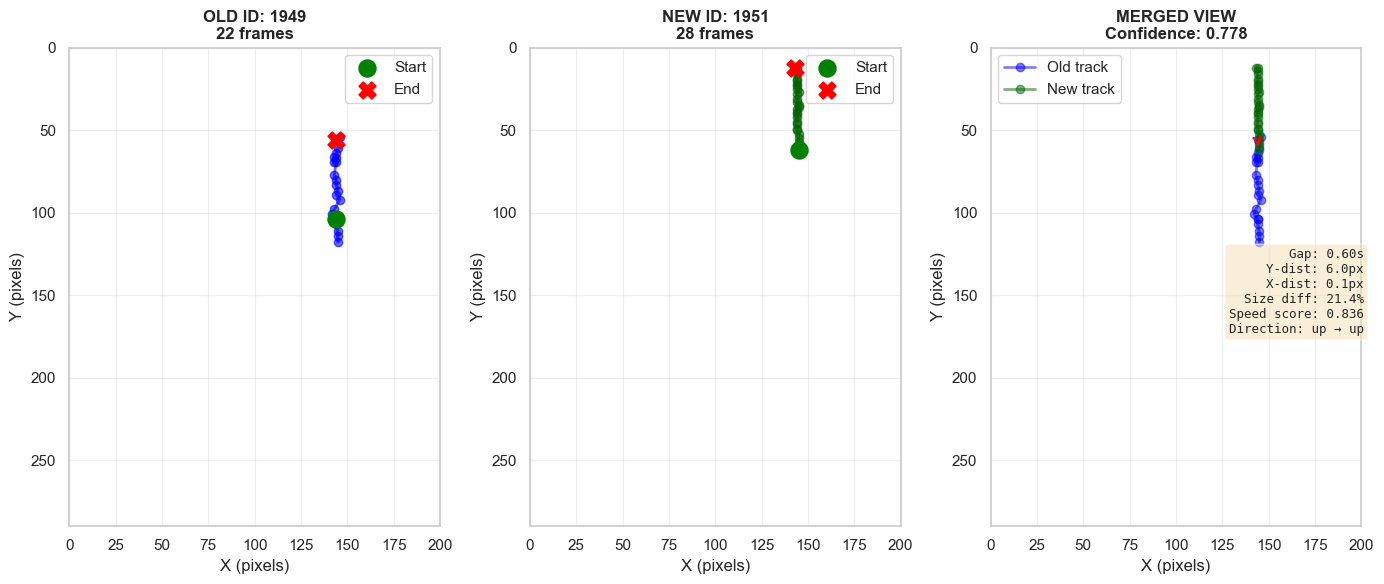


Pair 2/14:
  IDs: 2544 → 2546
  Confidence: 0.776
  Gap: 0.20s, Y-dist: 18.0px


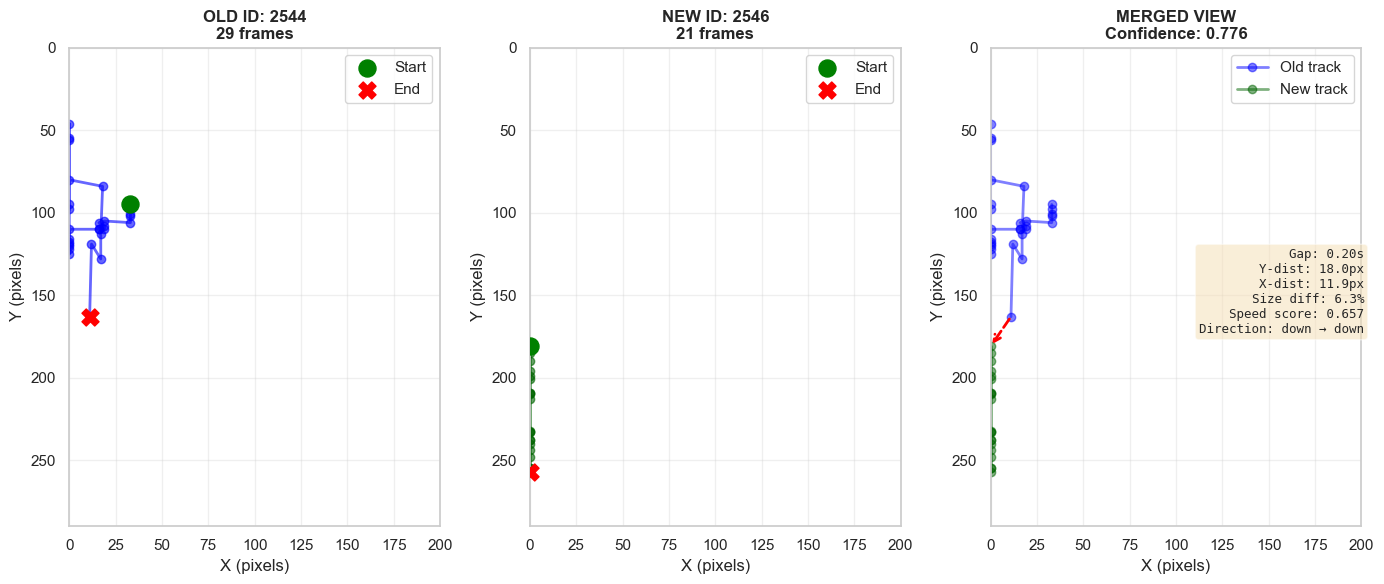


Pair 3/14:
  IDs: 2052 → 2061
  Confidence: 0.743
  Gap: 0.08s, Y-dist: 0.0px


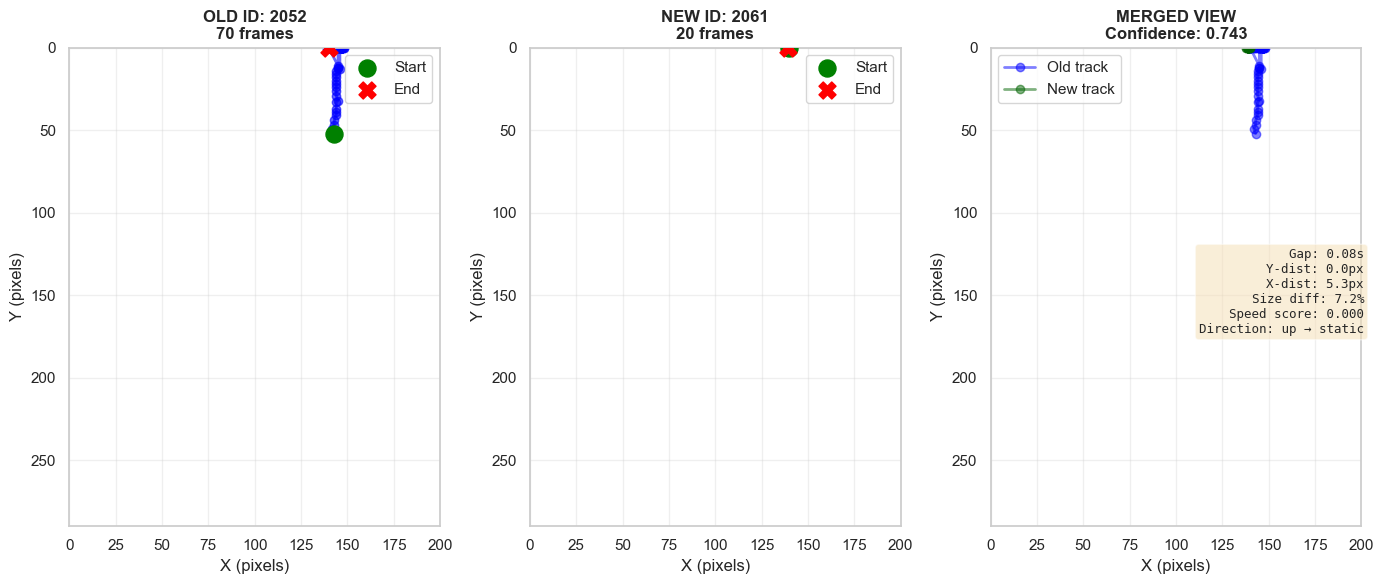

In [109]:
# Example 3: Visualize top confidence pairs
print("\n" + "="*60)
print("VISUALIZING TOP 3 MERGE PAIRS")
print("="*60)

if len(merge_results_fiorenzo) > 0:
    for idx in range(min(3, len(merge_results_fiorenzo))):
        print(f"\nPair {idx+1}/{len(merge_results_fiorenzo)}:")
        print(f"  IDs: {merge_results_fiorenzo.iloc[idx]['old_id']} → {merge_results_fiorenzo.iloc[idx]['new_id']}")
        print(f"  Confidence: {merge_results_fiorenzo.iloc[idx]['confidence']:.3f}")
        print(f"  Gap: {merge_results_fiorenzo.iloc[idx]['gap_sec']:.2f}s, Y-dist: {merge_results_fiorenzo.iloc[idx]['y_dist']:.1f}px")
        visualize_merge_pair_fiorenzo(session_df, merge_results_fiorenzo.iloc[idx])
else:
    print("No pairs to visualize")

In [110]:
# df['year'] = df['date_time'].dt.year
# df['month'] = df['date_time'].dt.month
# df['day'] = df['date_time'].dt.day
# df['hour'] = df['date_time'].dt.hour
# df['unique_vehicle_id'] = round(df['vehicle_id'] + df['year']/10000 + df['month']/1000000 + df['day']/100000000 + df['hour']/10000000000, 10)
# df['unique_frame_id'] = round(df['vehicle_id'] + df['year']/10000 + df['month']/1000000 + df['day']/100000000 + df['hour']/10000000000, 10)
# df.head()

In [111]:
# df['size'] = df['width'] * df['heigth']
# df.head()

In [112]:
# min_max_df = df.groupby('unique_vehicle_id')[['size', 'y']].agg(['max', 'min']).sort_index()

In [113]:
# min_max_df['way_size'] = min_max_df['y']['max'] - min_max_df['y']['min']
# min_max_df.columns = ['size_max', 'size_min', 'y_max', 'y_min', 'way_size']
# min_max_df.head()

In [114]:
# min_max_df['full_way'] = min_max_df['way_size'] > 240

In [115]:
# min_max_df['day'] = min_max_df.index.map(lambda x: True if 6 <= int((x* 10000000000)%100) < 18 else False)

In [116]:
# min_max_df

In [117]:
merge_results = find_merging_pairs_fiorenzo(final_summary)
print(f"Found pairs for merging: {len(merge_results)}")
print(merge_results.head())

Found pairs for merging: 45
   old_id  new_id  session_id  gap_sec  y_dist  x_dist  size_diff_pct  \
0    2015    2016           0    0.065       7    0.16           9.34   
1    2603    2604           0    0.062       3    5.16           8.78   
2    1757    1759           0    0.043       2    3.83           2.62   
3    2016    2017           0    0.097       6    1.27           6.85   
4    1017    1022           0    0.034       9   12.97          12.31   

   confidence  speed_score direction_a direction_b  frames_a  frames_b  
0       0.917        0.998          up          up        29        25  
1       0.894        0.791          up          up        64        20  
2       0.868        0.123          up          up        58        79  
3       0.852        0.284          up          up        25        46  
4       0.793        0.515        down        down        80        46  


TRAJECTORY PREDICTION-BASED MERGE DETECTION
TRAJECTORY PREDICTION-BASED MERGE DETECTION
Total tracks in summary: 341
Candidate tracks for merging: 157
Categories considered: ['RelayCandidate', 'Static']

Category distribution:
category
RelayCandidate    107
Static             50
Name: count, dtype: int64

Direction distribution:
_direction
down      101
up         28
static     28
Name: count, dtype: int64

RESULTS
Total merge pairs found: 20

----------------------------------------------------------------------
STATISTICS
----------------------------------------------------------------------

📊 Confidence scores:
  Range: 0.551 - 0.837
  Mean:  0.642
  Median: 0.616

🎯 Prediction errors (pixels):
  Range: 1.1 - 152.5
  Mean:  37.2
  Median: 23.5

⏱️  Time gaps (seconds):
  Range: 0.033 - 1.157
  Mean:  0.307

📏 Y-distances (pixels):
  Range: 0.0 - 147.0
  Mean:  25.4

📐 Width differences (%):
  Range: 2.0 - 150.5
  Mean:  28.0

🏆 Top 10 pairs by confidence:
 old_id  new_id  confidenc

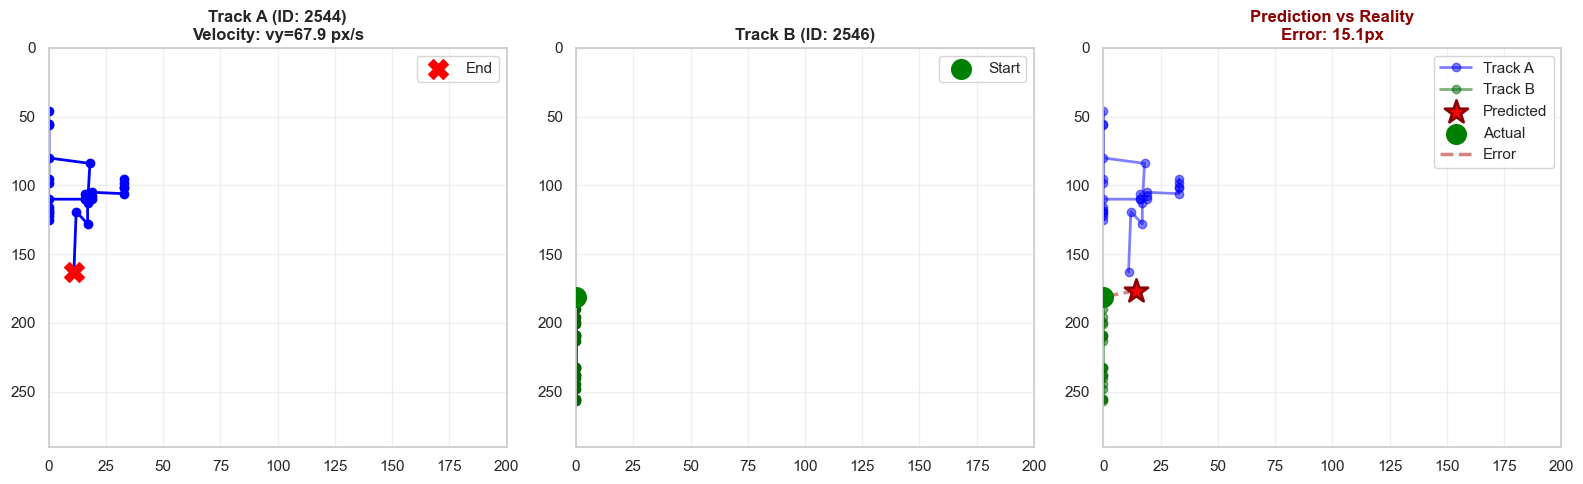


✅ Saved 42 pairs to: merge_pairs_trajectory_based.csv
✅ Saved comparison to: merge_methods_comparison.csv

DONE!


In [118]:
"""
Example Usage of find_merging_pairs_fiorenzo_2()

Copy these code blocks into new Jupyter notebook cells to test the function.
"""

# ============================================================================
# CELL 1: Import and Basic Test
# ============================================================================

from trajectory_merge_function import find_merging_pairs_fiorenzo_2

# Test with default balanced parameters
print("="*70)
print("TRAJECTORY PREDICTION-BASED MERGE DETECTION")
print("="*70)

pairs_traj = find_merging_pairs_fiorenzo_2(
    final_summary,
    categories=['RelayCandidate', 'Static'],
    max_time_gap=2.0,
    max_prediction_error=60,
    max_width_diff=0.25,
    min_confidence=0.55,
    verbose=True
)

print(f"\n✅ Found {len(pairs_traj)} pairs using trajectory prediction!")
if len(pairs_traj) > 0:
    print("\nFirst 5 pairs:")
    print(pairs_traj[['old_id', 'new_id', 'confidence', 'prediction_error',
                      'gap_sec', 'direction_a', 'direction_b']].head())


# ============================================================================
# CELL 2: Compare All Three Methods
# ============================================================================

print("\n" + "="*70)
print("COMPARISON: All Three Functions")
print("="*70)

# Original function
pairs_original = find_merging_pairs(final_summary)

# First improvement (confidence-based)
pairs_fiorenzo_1 = find_merging_pairs_fiorenzo(
    final_summary,
    categories=['RelayCandidate', 'Static'],
    min_confidence=0.45,
    verbose=False
)

# New trajectory-based function
pairs_fiorenzo_2 = find_merging_pairs_fiorenzo_2(
    final_summary,
    min_confidence=0.45,
    verbose=False
)

print(f"\nOriginal function:     {len(pairs_original):2d} pairs")
print(f"Fiorenzo v1 (conf):    {len(pairs_fiorenzo_1):2d} pairs")
print(f"Fiorenzo v2 (traj):    {len(pairs_fiorenzo_2):2d} pairs")
print(f"\nImprovement v1 → v2:   +{len(pairs_fiorenzo_2) - len(pairs_fiorenzo_1)} pairs")

# Analyze overlap
if len(pairs_fiorenzo_2) > 0 and len(pairs_fiorenzo_1) > 0:
    traj_pairs_set = set(zip(pairs_fiorenzo_2['old_id'], pairs_fiorenzo_2['new_id']))
    fior1_pairs_set = set(zip(pairs_fiorenzo_1['old_id'], pairs_fiorenzo_1['new_id']))

    common = traj_pairs_set & fior1_pairs_set
    unique_traj = traj_pairs_set - fior1_pairs_set
    unique_fior1 = fior1_pairs_set - traj_pairs_set

    print(f"\n📊 Overlap Analysis:")
    print(f"  Common to both:         {len(common)}")
    print(f"  Unique to trajectory:   {len(unique_traj)}")
    print(f"  Unique to fiorenzo v1:  {len(unique_fior1)}")


# ============================================================================
# CELL 3: Parameter Tuning
# ============================================================================

print("\n" + "="*70)
print("PARAMETER TUNING")
print("="*70)

configs = [
    ("Strict", {'max_time_gap': 2.0, 'max_prediction_error': 60,
                'max_width_diff': 0.25, 'min_confidence': 0.55}),
    ("Balanced", {'max_time_gap': 2.5, 'max_prediction_error': 80,
                  'max_width_diff': 0.35, 'min_confidence': 0.45}),
    ("Relaxed", {'max_time_gap': 3.0, 'max_prediction_error': 100,
                 'max_width_diff': 0.45, 'min_confidence': 0.35})
]

for name, params in configs:
    result = find_merging_pairs_fiorenzo_2(final_summary, **params, verbose=False)
    if len(result) > 0:
        avg_conf = result['confidence'].mean()
        avg_err = result['prediction_error'].mean()
        print(f"{name:10s}: {len(result):2d} pairs | "
              f"avg_conf={avg_conf:.3f} | avg_pred_err={avg_err:.1f}px")
    else:
        print(f"{name:10s}:  0 pairs")


# ============================================================================
# CELL 4: Detailed Statistics
# ============================================================================

if len(pairs_fiorenzo_2) > 0:
    print("\n" + "="*70)
    print("DETAILED STATISTICS")
    print("="*70)

    df = pairs_fiorenzo_2

    print("\n📊 Confidence Distribution:")
    print(df['confidence'].describe())

    print("\n🎯 Prediction Error Distribution (pixels):")
    print(df['prediction_error'].describe())

    print("\n⏱️  Time Gap Distribution (seconds):")
    print(df['gap_sec'].describe())

    print("\n🧭 Direction Pairs:")
    direction_pairs = df.groupby(['direction_a', 'direction_b']).size()
    print(direction_pairs)

    print("\n🏆 Top 10 by Confidence:")
    print(df[['old_id', 'new_id', 'confidence', 'prediction_error',
              'gap_sec', 'y_dist']].head(10).to_string(index=False))


# ============================================================================
# CELL 5: Visualize Top Pair
# ============================================================================

if len(pairs_fiorenzo_2) > 0:
    import matplotlib.pyplot as plt
    from trajectory_merge_function import _calculate_velocity, _predict_position

    print("\n" + "="*70)
    print("VISUALIZING TOP PAIR WITH TRAJECTORY PREDICTION")
    print("="*70)

    # Get top pair
    merge_row = pairs_fiorenzo_2.iloc[0]
    old_id = merge_row['old_id']
    new_id = merge_row['new_id']

    print(f"\nPair: {old_id} → {new_id}")
    print(f"Confidence: {merge_row['confidence']:.3f}")
    print(f"Prediction Error: {merge_row['prediction_error']:.1f}px")
    print(f"Time Gap: {merge_row['gap_sec']:.2f}s")

    # Get track data
    old_track = session_df[session_df['vehicle_id'] == old_id].sort_values('date_time')
    new_track = session_df[session_df['vehicle_id'] == new_id].sort_values('date_time')

    # Get summary for velocity
    track_a_summary = final_summary[final_summary['vehicle_id'] == old_id].iloc[0]
    vx, vy, direction = _calculate_velocity(track_a_summary)

    # Predict position
    track_a_dict = track_a_summary.to_dict()
    track_a_dict['_vx'] = vx
    track_a_dict['_vy'] = vy
    predicted_x, predicted_y = _predict_position(track_a_dict, merge_row['gap_sec'])

    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    ROI_HEIGHT = 290
    ROI_WIDTH = 200

    # Plot 1: Track A with velocity
    ax1 = axes[0]
    ax1.set_xlim(0, ROI_WIDTH)
    ax1.set_ylim(0, ROI_HEIGHT)
    ax1.invert_yaxis()
    ax1.set_title(f'Track A (ID: {old_id})\nVelocity: vy={vy:.1f} px/s', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.plot(old_track['x'], old_track['y'], 'o-', color='blue', linewidth=2)
    ax1.scatter(old_track['x'].iloc[-1], old_track['y'].iloc[-1],
                color='red', s=200, marker='X', label='End', zorder=5)
    ax1.legend()

    # Plot 2: Track B
    ax2 = axes[1]
    ax2.set_xlim(0, ROI_WIDTH)
    ax2.set_ylim(0, ROI_HEIGHT)
    ax2.invert_yaxis()
    ax2.set_title(f'Track B (ID: {new_id})', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.plot(new_track['x'], new_track['y'], 'o-', color='darkgreen', linewidth=2)
    ax2.scatter(new_track['x'].iloc[0], new_track['y'].iloc[0],
                color='green', s=200, marker='o', label='Start', zorder=5)
    ax2.legend()

    # Plot 3: Prediction overlay
    ax3 = axes[2]
    ax3.set_xlim(0, ROI_WIDTH)
    ax3.set_ylim(0, ROI_HEIGHT)
    ax3.invert_yaxis()
    ax3.set_title(f'Prediction vs Reality\nError: {merge_row["prediction_error"]:.1f}px',
                  fontweight='bold', color='darkred')
    ax3.grid(True, alpha=0.3)

    # Both tracks
    ax3.plot(old_track['x'], old_track['y'], 'o-', color='blue', alpha=0.5,
             linewidth=2, label='Track A')
    ax3.plot(new_track['x'], new_track['y'], 'o-', color='darkgreen', alpha=0.5,
             linewidth=2, label='Track B')

    # Predicted vs actual
    ax3.scatter(predicted_x, predicted_y, color='red', s=300, marker='*',
                label='Predicted', zorder=6, edgecolors='darkred', linewidths=2)
    ax3.scatter(new_track['x'].iloc[0], new_track['y'].iloc[0],
                color='green', s=200, marker='o', label='Actual', zorder=5)

    # Error line
    ax3.plot([predicted_x, new_track['x'].iloc[0]],
             [predicted_y, new_track['y'].iloc[0]],
             'r--', linewidth=2.5, label='Error', alpha=0.7)

    ax3.legend()

    plt.tight_layout()
    plt.show()


# ============================================================================
# CELL 6: Save Results
# ============================================================================

if len(pairs_fiorenzo_2) > 0:
    # Save to CSV
    output_file = "merge_pairs_trajectory_based.csv"
    pairs_fiorenzo_2.to_csv(output_file, index=False)
    print(f"\n✅ Saved {len(pairs_fiorenzo_2)} pairs to: {output_file}")

    # Also save comparison
    comparison_data = {
        'Method': ['Original', 'Fiorenzo_v1_Confidence', 'Fiorenzo_v2_Trajectory'],
        'Pairs_Found': [len(pairs_original), len(pairs_fiorenzo_1), len(pairs_fiorenzo_2)],
        'Avg_Confidence': [
            pairs_original['size_diff_pct'].mean() if len(pairs_original) > 0 else 0,
            pairs_fiorenzo_1['confidence'].mean() if len(pairs_fiorenzo_1) > 0 else 0,
            pairs_fiorenzo_2['confidence'].mean() if len(pairs_fiorenzo_2) > 0 else 0
        ]
    }

    import pandas as pd
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df.to_csv("merge_methods_comparison.csv", index=False)
    print(f"✅ Saved comparison to: merge_methods_comparison.csv")

print("\n" + "="*70)
print("DONE!")
print("="*70)
